<a href="https://colab.research.google.com/github/ralph27/ZAKA-hands-on/blob/master/Vision_Transformer_for_Image_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer for Image Classification
----
© 2023, Zaka AI, Inc. All Rights Reserved.

In this notebook, we will visualize how transformers use attention mechanism in a Computer Vision environment. The basic ViT architecture is used, however with only one transformer layer with one (or four) head(s) for simplicity.

The model is trained on CIFAR-10 classification task.

## Installing and Importing Libraries

We need to install the libraries we are going to use:

**numpy**: library used for numerical operations

**tensorflow**: popular framework for deep learning

**keras**: high-level API for building and training neural networks, which is now integrade to TensorFlow

**tensorflow_addons**: repository of additional functionalities and custom layers for TensorFlow

**matplotlib**: library to create visualizations

**opencv(cv2)**: computer vision library useful for image processing. cv2_imshow allows us to display images directly on Colab

**imageio**: library for reading and writing a wide variety of image data

**PIL(Python Image Library)**: used for opening, manipulating and saving many different image formats

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 9.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
np.random.seed(1337)

import tensorflow as tf
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

import imageio

import PIL
from PIL import Image, ImageDraw, ImageFont

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Defining the Video Function
We create a function that will take our generated images and create a video of them. We will later download this video to watch it on our own machine.

In [ ]:
def make_video(movieName, img_list, att_list):
  with imageio.get_writer(movieName, mode='I') as writer:
      h,w = img_list[0].shape[0:2]
      for idx, img_i in enumerate(img_list):
        canvas = PIL.Image.new('RGBA', (w*2, h), 'black')
        canvas.paste(Image.fromarray(img_list[idx].astype(np.uint8)), (0, 0))
        feature_map = Image.fromarray(att_list[idx].astype(np.uint8))
        canvas.paste(feature_map, (w, 0))
        writer.append_data(np.array(canvas))

## Loading the Dataset
We now load our dataset from the keras datasets and already split into training and testing splits. We will load the cifar100 dataset from Keras.

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Preparing the Model

### Setting our hyperparameters
First thing we will do is set our hyperparamaters to be used later in our model. Doing things modularly is considered good practice, and facilitates the creation of multiple models later on.

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 15 # 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4 #4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1 #8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

### Augmenting our data
We create now a pipeline for data augmentation, which is increasing the amount of data available artifically by making slight changes in it.

However, in our case we will only normalize our data and resize it to a specific size defined earlier so that we can feed it to our model properly.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


### Creating the Multi-Layer Perceptron (MLP) Function

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


### Creating the Patches Layer
We create a custom Keras Layer that will extract image patches from our input images and reshape them into a useful format.

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


We can now visualize the patches in our images, we will take one example

Image size: 72 X 72 pixels
Patch size: 6 X 6 pixels
Patches per image: 144 (image_size // patch_size) ** 2
Elements per patch: 108 w*h*3


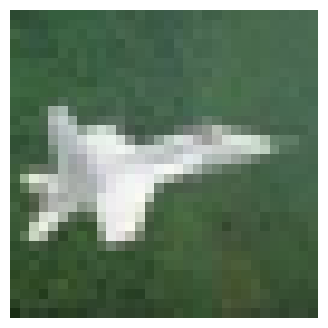

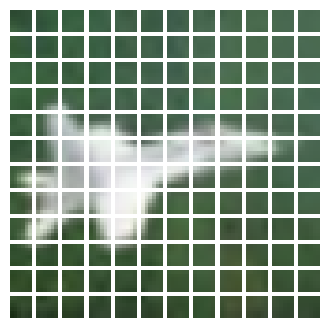

In [ ]:
plt.figure(figsize=(4, 4))
# image = x_train[np.random.choice(range(x_train.shape[0]))]

image = x_train[77]

plt.imshow(np.squeeze(image.astype("uint8")), cmap='gray')

plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size} pixels")
print(f"Patch size: {patch_size} X {patch_size} pixels")
print(f"Patches per image: {patches.shape[1]} (image_size // patch_size) ** 2")
print(f"Elements per patch: {patches.shape[-1]} w*h*3")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(np.squeeze(patch_img.numpy().astype("uint8")), cmap='gray')
    plt.axis("off")

### Creating the Patch Encoder Layer

We now create the PatchEncoder Keras Layer which is used to encode the Patches generated earlier and add positional information to them.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Creating the Model
With everything prepared, we can create our model and add our custom layers to it

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # no pos encoding!
    # encoded_patches = PatchEncoder2(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    # attention_scores_list = []
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output, attention_scores_items = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1, return_attention_scores=True)
        # attention_scores_list.append(attention_scores_items)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    model_att = keras.Model(inputs=inputs, outputs=attention_scores_items)
    return model, model_att

## Training and Evaluating the Model
We create now a function that will Train and Evaluate our model and save the best weights for later use.

We will pass the necessary parameters that we set earlier for the optimizer.

For the metrics, we will use Categorical Accuracy and TopK Categorical Accuracy = 5.

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print("-"*50)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

# We save it as a variable to run the function appropriately later on
vit_classifier, at_model = create_vit_classifier()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 72, 72, 3)            7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_1 (Patches)         (None, None, 108)            0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              16192     ['patches_1[0][0]']       

In [ ]:
at_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 72, 72, 3)            7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_1 (Patches)         (None, None, 108)            0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              16192     ['patches_1[0][0]']     

We will now use the run_experiment function the variable vit_classifier that we created earlier

In [ ]:
history = run_experiment(vit_classifier)

Epoch 1/15
176/176 [==============================] - 20s 72ms/step - loss: 2.0980 - accuracy: 0.3246 - top-5-accuracy: 0.8137 - val_loss: 1.5194 - val_accuracy: 0.4618 - val_top-5-accuracy: 0.9110
Epoch 2/15
176/176 [==============================] - 13s 72ms/step - loss: 1.5337 - accuracy: 0.4511 - top-5-accuracy: 0.9059 - val_loss: 1.2802 - val_accuracy: 0.5342 - val_top-5-accuracy: 0.9428
Epoch 3/15
176/176 [==============================] - 13s 71ms/step - loss: 1.3553 - accuracy: 0.5116 - top-5-accuracy: 0.9318 - val_loss: 1.1996 - val_accuracy: 0.5694 - val_top-5-accuracy: 0.9492
Epoch 4/15
176/176 [==============================] - 12s 69ms/step - loss: 1.2401 - accuracy: 0.5581 - top-5-accuracy: 0.9453 - val_loss: 1.1111 - val_accuracy: 0.6078 - val_top-5-accuracy: 0.9596
Epoch 5/15
176/176 [==============================] - 12s 67ms/step - loss: 1.1447 - accuracy: 0.5914 - top-5-accuracy: 0.9550 - val_loss: 1.0718 - val_accuracy: 0.6152 - val_top-5-accuracy: 0.9612
Epoch 6/15

## Visualizing our Results
Let's start by plotting some examples from our dataset

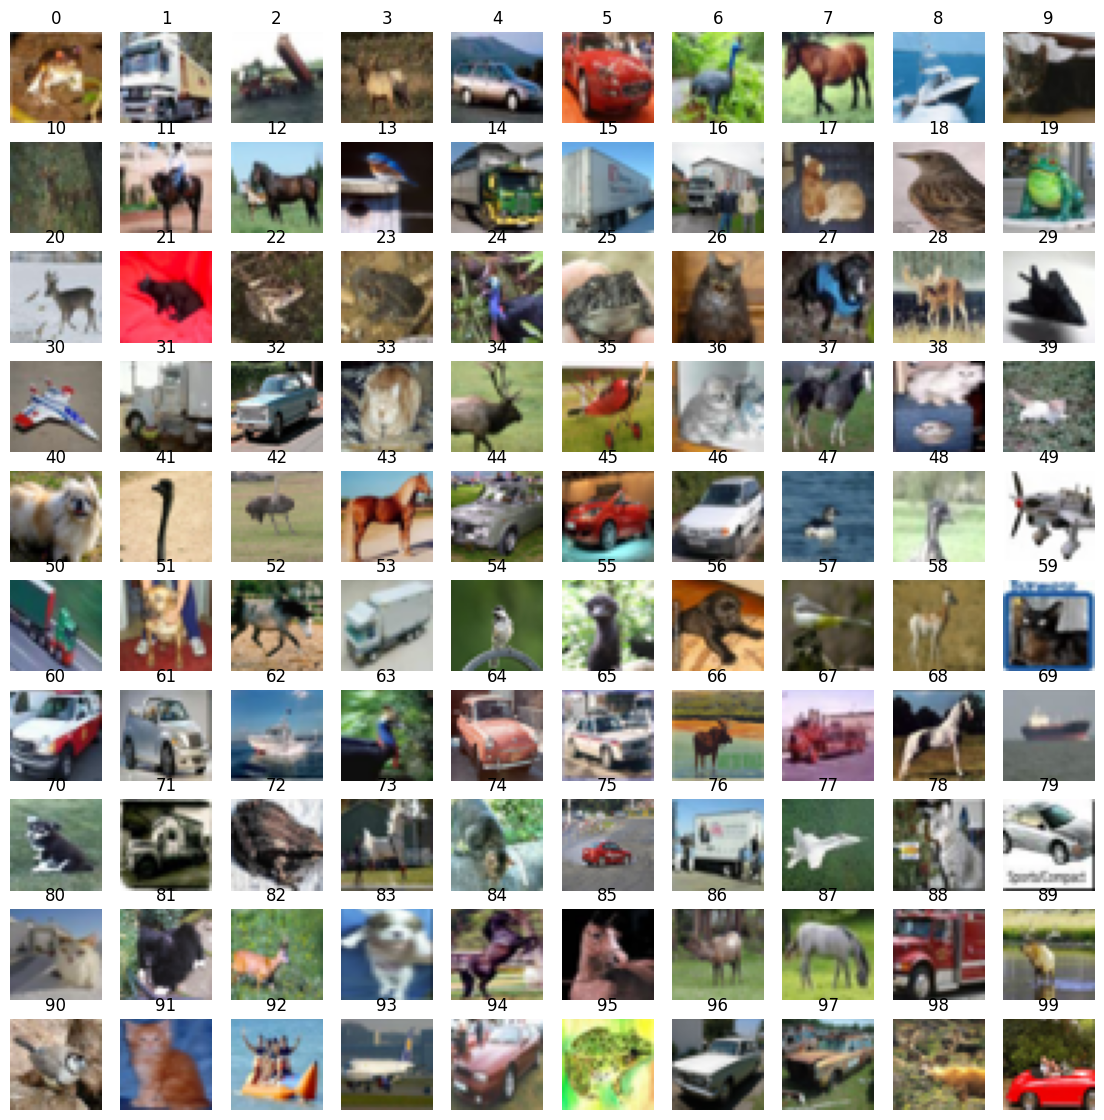

In [ ]:
plt.figure(figsize=(14, 14))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(np.squeeze(x_train[i]))
    plt.title(str(i))
    plt.axis("off")

Now, let's select one example that we will base our remaining experiments upon

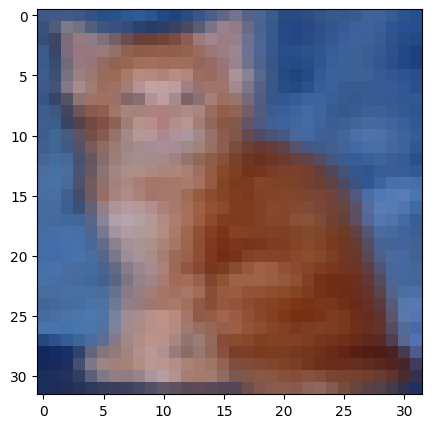

In [ ]:
selected_image_index = 91
plt.figure(figsize=(5, 5))
image = x_train[selected_image_index]
plt.imshow(np.squeeze(image))
plt.show()

Now we create a set of attention maps to display each self-attention head's scores in the multi-head attention we created

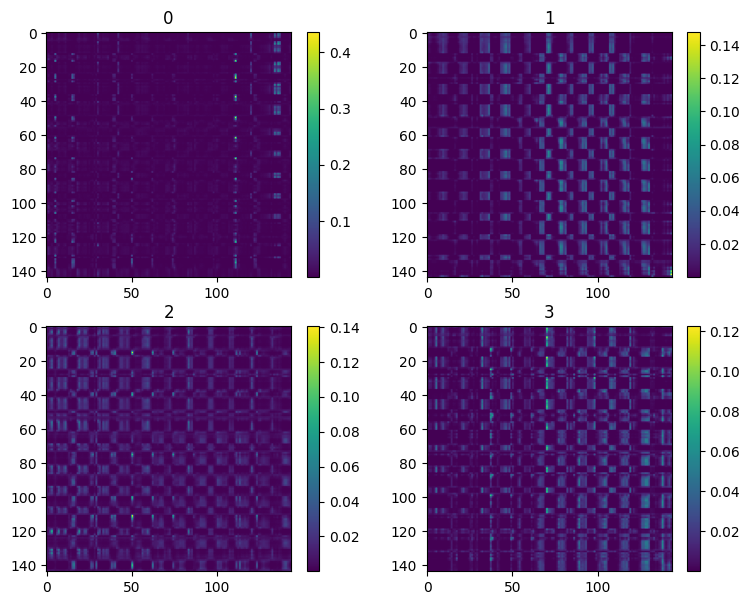

In [ ]:
plt.figure(figsize=(9, 7))
for h in range(4):
    ax = plt.subplot(2, 2, h + 1)
    att_results = at_model(np.expand_dims(x_train[selected_image_index], axis=0))
    plt.imshow(att_results[0,h,:])
    plt.title(str(h))
    plt.colorbar()

Now we will visualize the attention map for each attention head, we will create a video based on the generated images

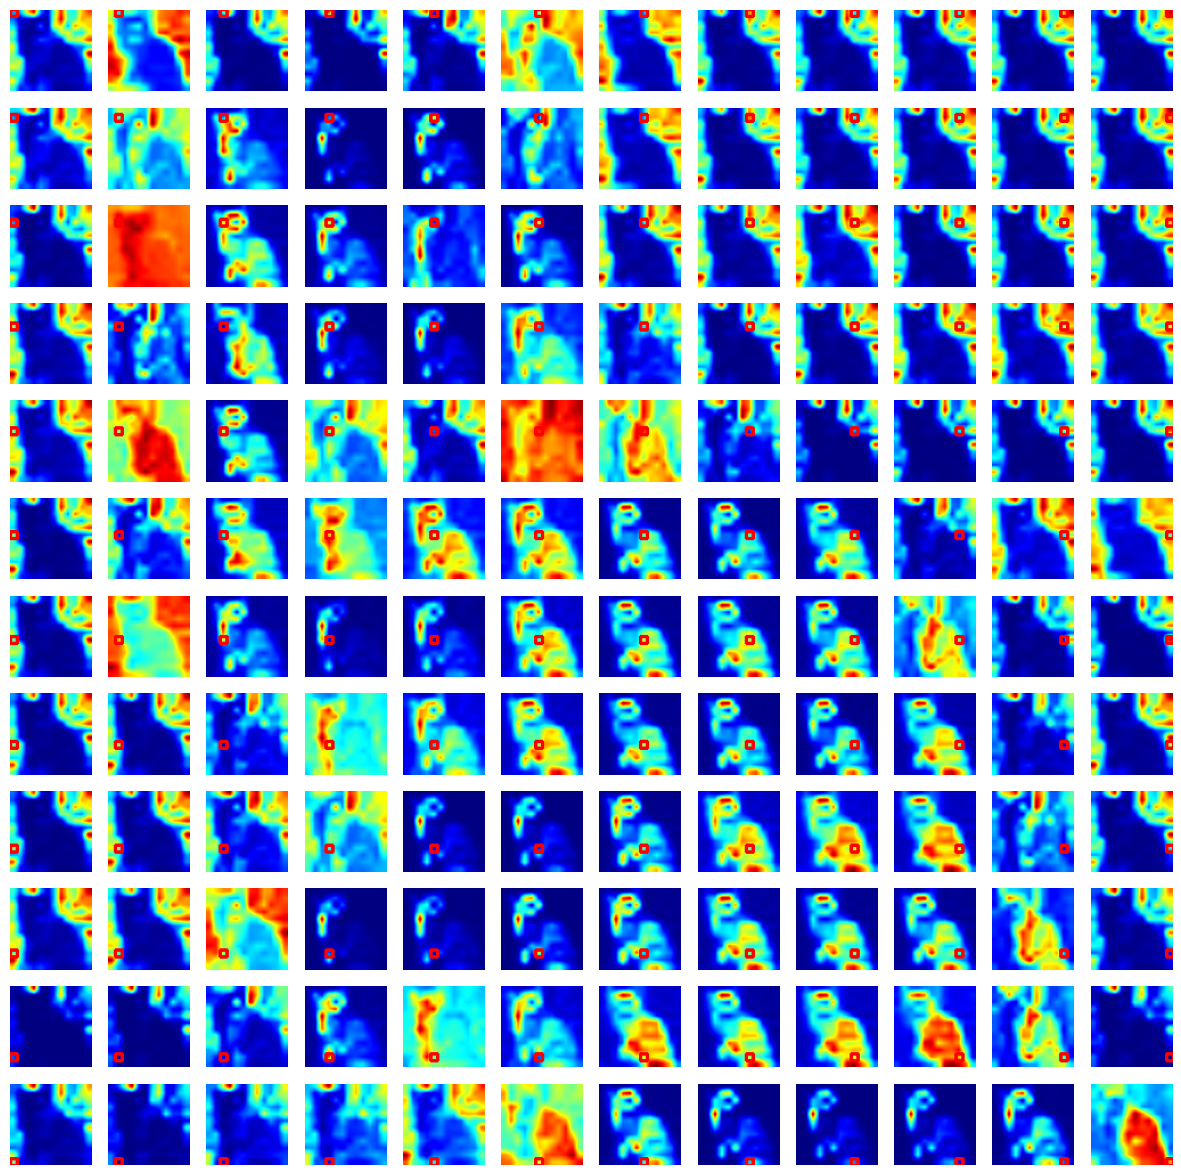

In [ ]:
head_index =  2
att_list = []
patch_list = []
std_list = []
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(15, 15))
for selected_q_index in range(n*n):
  ax = plt.subplot(n, n, selected_q_index + 1)

  att_mask  = tf.reshape(att_results[0, head_index, selected_q_index, :], [n, n])
  feature_map = att_mask.numpy()
  std_list.append(np.std(feature_map))
  feature_map /= np.max(feature_map)
  feature_map *= 255
  feature_map = np.clip(feature_map, 0, 255).astype('uint8')
  feature_map = cv2.resize(feature_map, (image_size, image_size))


  feature_map = cv2.applyColorMap(feature_map, cv2.COLORMAP_JET)
  feature_map = cv2.cvtColor(feature_map, cv2.COLOR_BGR2RGB)

  image_patch = cv2.resize(image, (image_size, image_size))
  n = int(np.sqrt(num_patches))
  x = selected_q_index % n
  y = selected_q_index // n
  cv2.rectangle(feature_map, (x*patch_size, y*patch_size), ((x*patch_size)+patch_size, (y*patch_size)+patch_size), 255, 2)
  cv2.rectangle(image_patch, (x*patch_size, y*patch_size), ((x*patch_size)+patch_size, (y*patch_size)+patch_size), 255, 2)

  # feature_map = feature_map + (0.3 * image_patch).astype('uint8')
  # image_patch = image_patch + (0.3 * feature_map).astype('uint8')
  image_patch = cv2.addWeighted(image_patch,1.0,feature_map,0.2,0)
  att_list.append(feature_map)
  patch_list.append(image_patch)
  # cv2_imshow(feature_map)
  plt.imshow(feature_map)
  # plt.imshow(image_patch)
  #plt.imshow(image_patch, cmap='gray')
  # cv2_imshow(feature_map)
  plt.axis("off")


## Creating our Video
We now create a video from the heatmap images above. We will do that by using the make_video function

In [ ]:
make_video('att_cifar_L1H1_91_h3.mp4', patch_list, att_list)

We get a warning saying that the input image is not in the correct dimensions. Now we will resize each patch image to the specified size.

In [ ]:
import cv2
import numpy as np

# Load the patch_list variable (assuming it's a list of image patches)
# patch_list should contain a list of numpy arrays, each representing an image patch

# Define a function to resize an individual patch to the nearest multiple of 16
def resize_patch(patch):
    new_width = ((patch.shape[1] + 15) // 16) * 16
    new_height = ((patch.shape[0] + 15) // 16) * 16
    resized_patch = cv2.resize(patch, (new_width, new_height))
    return resized_patch

# Resize each patch in the patch_list
resized_patch_list = [resize_patch(patch) for patch in patch_list]

# Now, resized_patch_list contains the resized patches, and you can proceed with your video creation process


Let's run the make_video function again

In [ ]:
make_video('att_cifar_L1H1_91_h3.mp4', resized_patch_list, att_list)

Download the video locally and enjoy!